# LS100: Joint Angles & Derived Metrics
This notebook takes **2D pose landmarks** produced by the previous notebook and computes **biomechanical joint angles** per frame. It also provides plotting utilities to visualize angle trajectories over time.

## Goal
**Compute biomechanical joint angles from pose landmark data.**  
You will define which angles to compute (e.g., left elbow, right knee) by specifying three landmarks `(A, B, C)` that form the angle at **B** (∠ABC).

### Imports and Environment Check (Code)

In [16]:
# In case you need to install any packages (like `plotly` or `seaborn`), uncomment and run the following line:
# %pip install plotly seaborn

In [1]:
# Imports & Environment Check
import sys, os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as px

# Optional (requested) for nicer charts
try:
    import seaborn as sns  # noqa: F401
    _HAS_SEABORN = True
except Exception:
    _HAS_SEABORN = False

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy :", np.__version__)
print("Plotly:", px.__version__)
print("Seaborn available:", _HAS_SEABORN)


Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Pandas: 2.3.3
NumPy : 1.26.4
Plotly: 6.4.0
Seaborn available: True


### Load 2D Pose CSV

In [299]:
# 5) Load 2D Pose CSV
# Set the path to your *_pose2d.csv (raw or *_filtered.csv) from Notebook 1.
pose2d_csv_path = r"/Users/Owner/Documents/2D_Poses/ExpertUpwardFacingDog5_pose2d.csv"  # ← replace as needed

df = pd.read_csv(pose2d_csv_path)
print("Loaded:", pose2d_csv_path, "shape:", df.shape)
print("Columns:", list(df.columns))
if "landmark_name" in df.columns:
    print("Landmark names:", df["landmark_name"].unique()[:40])
df.head(3)


Loaded: /Users/Owner/Documents/2D_Poses/ExpertUpwardFacingDog5_pose2d.csv shape: (14718, 9)
Columns: ['video', 'frame', 'time_ms', 'landmark_index', 'landmark_name', 'x', 'y', 'z', 'visibility']
Landmark names: ['nose' 'left_eye_inner' 'left_eye' 'left_eye_outer' 'right_eye_inner'
 'right_eye' 'right_eye_outer' 'left_ear' 'right_ear' 'mouth_left'
 'mouth_right' 'left_shoulder' 'right_shoulder' 'left_elbow' 'right_elbow'
 'left_wrist' 'right_wrist' 'left_pinky' 'right_pinky' 'left_index'
 'right_index' 'left_thumb' 'right_thumb' 'left_hip' 'right_hip'
 'left_knee' 'right_knee' 'left_ankle' 'right_ankle' 'left_heel'
 'right_heel' 'left_foot_index' 'right_foot_index']


,video,frame,time_ms,landmark_index,landmark_name,x,y,z,visibility
0,ExpertUpwardFacingDog5.MP4,0,0,0,nose,0.346218,0.367585,0.047996,0.999767
1,ExpertUpwardFacingDog5.MP4,0,0,1,left_eye_inner,0.356519,0.356807,0.035339,0.999854
2,ExpertUpwardFacingDog5.MP4,0,0,2,left_eye,0.358160,0.359609,0.035068,0.999821


## Define Custom Angles
Provide a list of angle definitions. Each item defines the angle at **B** formed by points **A–B–C**.

**Example:**
```python
angle_defs = [
    {"name": "left_elbow",  "A": "left_shoulder", "B": "left_elbow", "C": "left_wrist"},
    {"name": "right_knee",  "A": "right_hip",     "B": "right_knee", "C": "right_ankle"},
]


In [292]:

# Edit this list for your work:
angle_defs = [
    {"name": "right_knee", "A": "right_heel", "B": "right_knee", "C": "right_hip"},
    {"name": "left_knee", "A": "left_heel","B": "left_knee","C": "left_hip"},
    {"name": "right_elbow", "A": "right_wrist", "B": "right_elbow", "C": "right_shoulder"},
    {"name": "left_elbow", "A": "left_wrist", "B": "left_elbow", "C": "left_shoulder"},
    {"name": "left_shoulder", "A": "left_hip", "B": "left_shoulder", "C": "left_elbow"},
    {"name": "right_shoulder", "A": "right_hip", "B": "right_shoulder", "C": "right_elbow"},
    {"name": "left_hip", "A": "left_knee", "B": "left_hip", "C": "left_shoulder"},
    {"name": "right_hip", "A": "right_knee", "B": "right_hip", "C": "right_shoulder"},
]
angle_defs

[{'name': 'right_knee',
  'A': 'right_heel',
  'B': 'right_knee',
  'C': 'right_hip'},
 {'name': 'left_knee', 'A': 'left_heel', 'B': 'left_knee', 'C': 'left_hip'},
 {'name': 'right_elbow',
  'A': 'right_wrist',
  'B': 'right_elbow',
  'C': 'right_shoulder'},
 {'name': 'left_elbow',
  'A': 'left_wrist',
  'B': 'left_elbow',
  'C': 'left_shoulder'},
 {'name': 'left_shoulder',
  'A': 'left_hip',
  'B': 'left_shoulder',
  'C': 'left_elbow'},
 {'name': 'right_shoulder',
  'A': 'right_hip',
  'B': 'right_shoulder',
  'C': 'right_elbow'},
 {'name': 'left_hip', 'A': 'left_knee', 'B': 'left_hip', 'C': 'left_shoulder'},
 {'name': 'right_hip',
  'A': 'right_knee',
  'B': 'right_hip',
  'C': 'right_shoulder'}]

### Computation Angles

#### Angle Computation Function

* The following function calculates the angles you defined.
* Please change the `visibility_thresh` according to your desire. This will determine the 'confidence' in each angle in each frame.

"good" → all three landmarks ≥ threshold  
"low" → exactly one landmark < threshold  
"least" → two or three landmarks < threshold


In [293]:
# User threshold for angle confidence (edit if desired)
visibility_thresh = 0.5  # used only for confidence labels here

def _wide_xyv(df2d: pd.DataFrame) -> pd.DataFrame:
    """
    Pivot to wide format with index (video, frame, time_ms) and columns:
      x_<landmark>, y_<landmark>, v_<landmark>
    If 'visibility' is missing, v_<landmark> defaults to 1.0 (assume good).
    """
    w_x = df2d.pivot_table(index=["video","frame","time_ms"], columns="landmark_name", values="x")
    w_y = df2d.pivot_table(index=["video","frame","time_ms"], columns="landmark_name", values="y")
    if "visibility" in df2d.columns:
        w_v = df2d.pivot_table(index=["video","frame","time_ms"], columns="landmark_name", values="visibility").fillna(0.0)
    else:
        w_v = pd.DataFrame(1.0, index=w_x.index, columns=w_x.columns)

    w_x.columns = [f"x_{c}" for c in w_x.columns]
    w_y.columns = [f"y_{c}" for c in w_y.columns]
    w_v.columns = [f"v_{c}" for c in w_v.columns]

    w = pd.concat([w_x, w_y, w_v], axis=1).sort_index()
    return w

def _angle_at_B(A_pts: np.ndarray, B_pts: np.ndarray, C_pts: np.ndarray) -> np.ndarray:
    """
    Compute angle at B for triplets (A, B, C) for all rows.
    Expects arrays [N,2]. Returns degrees in [0,180].
    """
    BA = A_pts - B_pts
    BC = C_pts - B_pts
    denom = (np.linalg.norm(BA, axis=1) * np.linalg.norm(BC, axis=1)) + 1e-9
    cosang = (BA * BC).sum(1) / denom
    cosang = np.clip(cosang, -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

def compute_angles(df2d: pd.DataFrame, defs: list, visibility_thresh: float = 0.5) -> pd.DataFrame:
    """
    Returns a DataFrame with (video, frame, time_ms) + per-angle columns:
      angle_<name>           (float degrees)
      confidence_<name>      ('good' | 'low' | 'least')

    Confidence rule per frame for a given angle:
      - 'good'  : all A/B/C vis >= threshold
      - 'low'   : exactly one of A/B/C vis < threshold
      - 'least' : two or three of A/B/C vis < threshold
    """
    w = _wide_xyv(df2d)
    out = pd.DataFrame(index=w.index)

    for d in defs:
        A, B, C = d["A"], d["B"], d["C"]
        name = d["name"]
        cols_needed = [f"x_{A}", f"y_{A}", f"x_{B}", f"y_{B}", f"x_{C}", f"y_{C}",
                       f"v_{A}", f"v_{B}", f"v_{C}"]
        missing = [c for c in cols_needed if c not in w.columns]
        if missing:
            print(f"Warning: missing columns for angle '{name}': {missing}. Skipping.")
            continue

        # assemble points
        A_pts = np.c_[w[f"x_{A}"].values, w[f"y_{A}"].values]
        B_pts = np.c_[w[f"x_{B}"].values, w[f"y_{B}"].values]
        C_pts = np.c_[w[f"x_{C}"].values, w[f"y_{C}"].values]
        ang   = _angle_at_B(A_pts, B_pts, C_pts)

        # confidence per frame for this angle
        vA = w[f"v_{A}"].fillna(0.0).values
        vB = w[f"v_{B}"].fillna(0.0).values
        vC = w[f"v_{C}"].fillna(0.0).values
        below = (vA < visibility_thresh).astype(int) + (vB < visibility_thresh).astype(int) + (vC < visibility_thresh).astype(int)

        conf = np.where(below == 0, "good", np.where(below == 1, "low", "least"))

        # write columns
        out[f"angle_{name}"] = ang
        out[f"confidence_{name}"] = conf

    return out.reset_index()


#### 6.b Core logic to compute ∠ABC

In [300]:
angles_df = compute_angles(df, angle_defs, visibility_thresh=visibility_thresh)
print("Angles shape:", angles_df.shape)
angles_df.head()

Angles shape: (446, 19)


,video,frame,time_ms,angle_right_knee,confidence_right_knee,angle_left_knee,confidence_left_knee,angle_right_elbow,confidence_right_elbow,angle_left_elbow,confidence_left_elbow,angle_left_shoulder,confidence_left_shoulder,angle_right_shoulder,confidence_right_shoulder,angle_left_hip,confidence_left_hip,angle_right_hip,confidence_right_hip
0,ExpertUpwardFacingDog5.MP4,0,0,160.178992,low,152.204634,good,171.912672,least,175.767129,good,15.475315,good,12.923131,low,135.718533,good,131.058308,low
1,ExpertUpwardFacingDog5.MP4,1,33,162.259045,low,152.398447,good,171.754472,least,175.436299,good,15.765937,good,13.282383,low,135.839753,good,130.467296,low
2,ExpertUpwardFacingDog5.MP4,2,66,162.611418,low,152.588581,good,170.927138,least,175.259336,good,16.152153,good,13.419826,low,136.222247,good,130.571855,low
3,ExpertUpwardFacingDog5.MP4,3,100,162.920921,low,154.097393,good,170.838191,least,174.813880,good,16.390732,good,13.836488,low,135.696185,good,130.605622,low
4,ExpertUpwardFacingDog5.MP4,4,133,163.068909,low,155.687609,good,171.013959,least,174.647863,good,16.746177,good,14.329593,low,135.064050,good,130.807480,low


### Save and Inspect Output

In [301]:
pose2d_csv = Path(pose2d_csv_path)
out_dir = pose2d_csv.parent
angles_out = out_dir / f"{pose2d_csv.stem}_angles.csv"
angles_df.to_csv(angles_out, index=False)

print("Saved angles to:", angles_out)
pd.read_csv(angles_out).head()


Saved angles to: \Users\Owner\Documents\2D_Poses\ExpertUpwardFacingDog5_pose2d_angles.csv


,video,frame,time_ms,angle_right_knee,confidence_right_knee,angle_left_knee,confidence_left_knee,angle_right_elbow,confidence_right_elbow,angle_left_elbow,confidence_left_elbow,angle_left_shoulder,confidence_left_shoulder,angle_right_shoulder,confidence_right_shoulder,angle_left_hip,confidence_left_hip,angle_right_hip,confidence_right_hip
0,ExpertUpwardFacingDog5.MP4,0,0,160.178992,low,152.204634,good,171.912672,least,175.767129,good,15.475315,good,12.923131,low,135.718533,good,131.058308,low
1,ExpertUpwardFacingDog5.MP4,1,33,162.259045,low,152.398447,good,171.754472,least,175.436299,good,15.765937,good,13.282383,low,135.839753,good,130.467296,low
2,ExpertUpwardFacingDog5.MP4,2,66,162.611418,low,152.588581,good,170.927138,least,175.259336,good,16.152153,good,13.419826,low,136.222247,good,130.571855,low
3,ExpertUpwardFacingDog5.MP4,3,100,162.920921,low,154.097393,good,170.838191,least,174.813880,good,16.390732,good,13.836488,low,135.696185,good,130.605622,low
4,ExpertUpwardFacingDog5.MP4,4,133,163.068909,low,155.687609,good,171.013959,least,174.647863,good,16.746177,good,14.329593,low,135.064050,good,130.807480,low


### Plotting the computed angles over time (matplotlib AND seaborn)

## 8) Plot Angles with Confidence Highlights

In this section, we visualize the computed joint angles for each frame.  
You can choose between **Matplotlib**, **Seaborn**, or **Plotly** for plotting:

- **Matplotlib** → simple, fast static plots.  
- **Seaborn** → adds smoothing and styling for a cleaner look.  
- **Plotly** → fully interactive charts with zoom, hover, and export options.

Each plot corresponds to one computed angle (e.g., `angle_left_knee`, `angle_right_elbow`, etc.).  
Colored transparent vertical patches mark frames with lower landmark visibility confidence:

- 🟡 **Yellow** → “low” confidence (one landmark below threshold)  
- 🟠 **Orange** → “least” confidence (two or three landmarks below threshold)

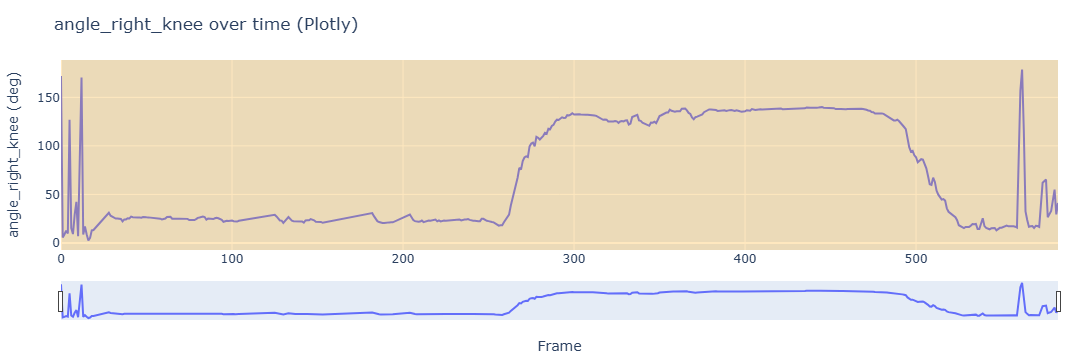

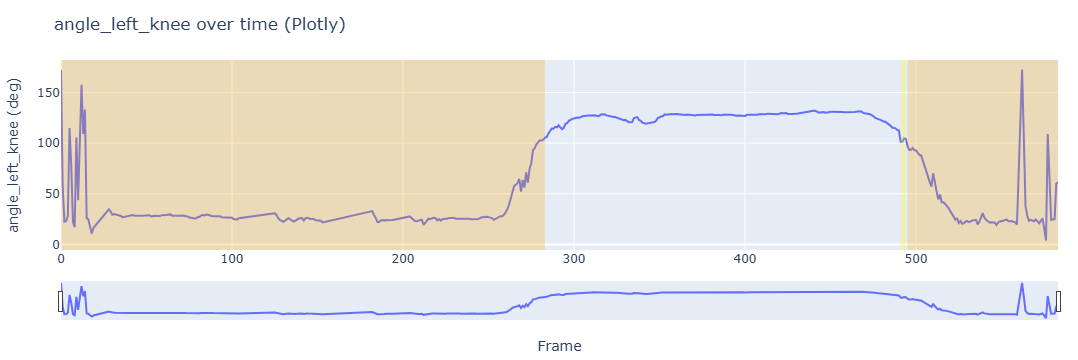

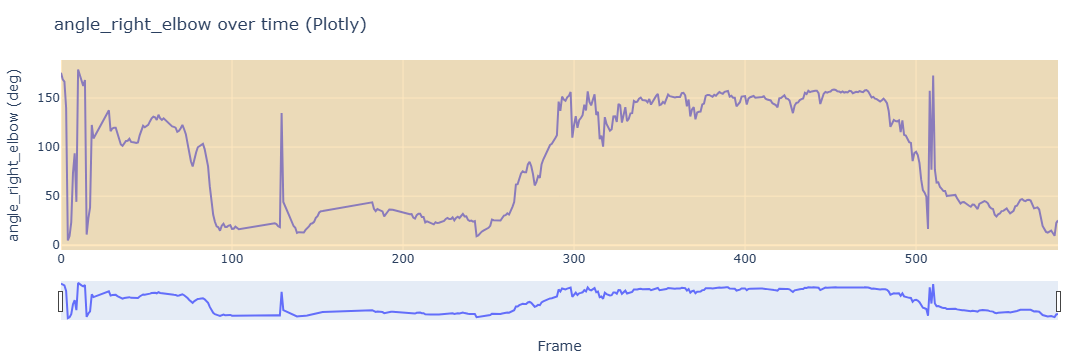

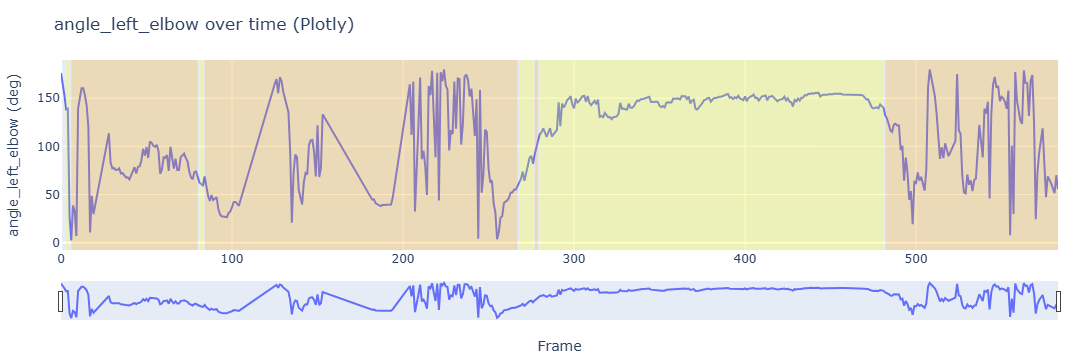

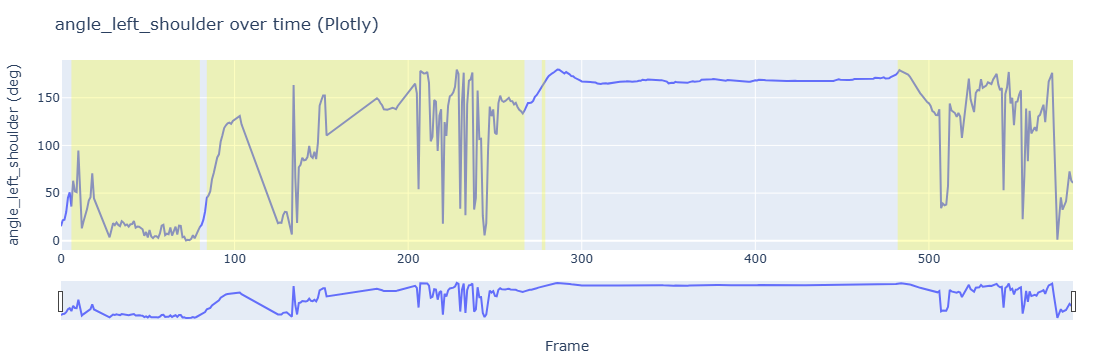

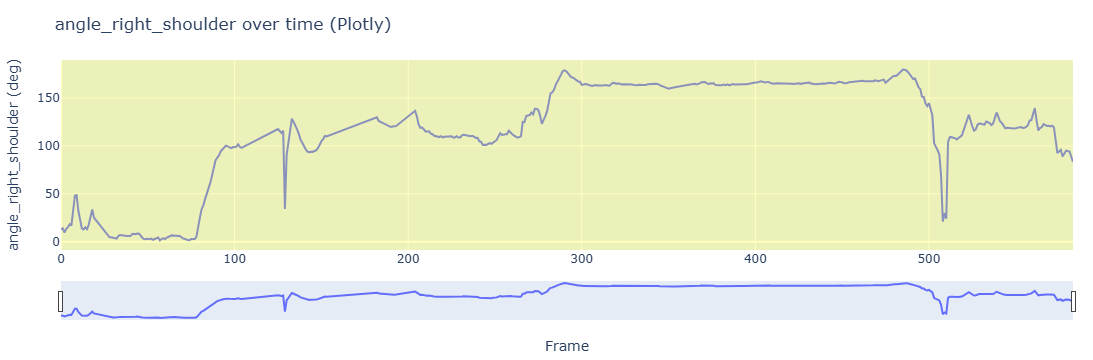

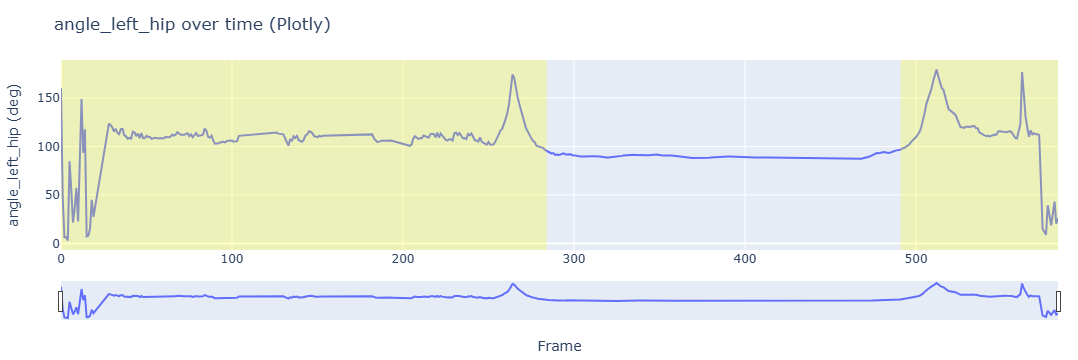

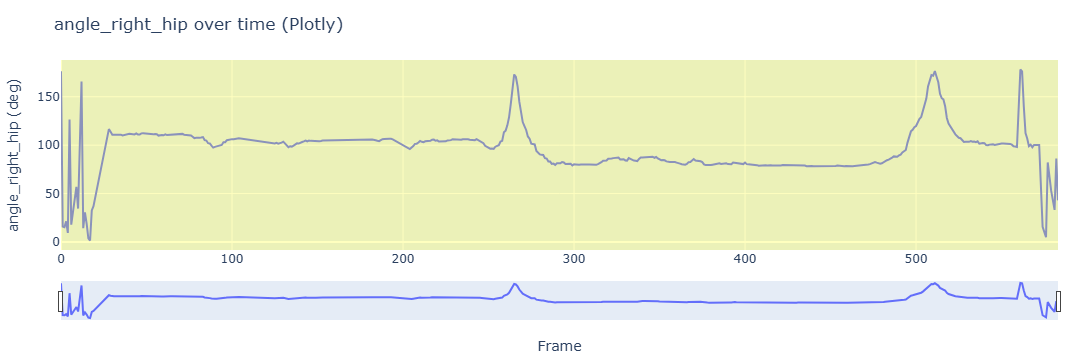

In [7]:
# ======================================================
# 8) Plotting the computed angles over time (ALL angles)
#    with confidence patches ("low" = yellow, "least" = orange)
#    Choose backend: "matplotlib", "seaborn", or "plotly"
# ======================================================

# --- User choices ---
plot_backend   = "plotly"   # "matplotlib" | "seaborn" | "plotly"
selected_video = None       # set to a specific video filename to filter, or leave as None

# --- Prep & validation ---
if "angles_df" not in globals():
    raise RuntimeError("angles_df not found. Run the angle computation cells first.")

angle_cols = [c for c in angles_df.columns if c.startswith("angle_")]
if not angle_cols:
    raise ValueError("No angle columns found (columns starting with 'angle_').")

# helper: find contiguous spans where predicate(series) is True
def _spans_from_labels(frame_series, label_series, label_value):
    """Return a list of (x0, x1) inclusive frame spans where label_series == label_value."""
    frames = frame_series.to_numpy()
    labels = (label_series.to_numpy() == label_value)
    spans = []
    if frames.size == 0:
        return spans
    start = None
    last_frame = None
    for f, ok in zip(frames, labels):
        if ok and start is None:
            start = f
        if ok:
            last_frame = f
        if (not ok) and (start is not None):
            spans.append((start, last_frame))
            start = None
    if start is not None:
        spans.append((start, last_frame))
    return spans

df_plot = angles_df.copy()
if selected_video is not None:
    df_plot = df_plot[df_plot["video"] == selected_video]
    if df_plot.empty:
        raise ValueError(f"No rows found for video '{selected_video}' in angles_df.")

title_suffix = f" — {selected_video}" if selected_video else ""
backend = plot_backend.strip().lower()

if backend == "matplotlib":
    import matplotlib.pyplot as plt

    for col in angle_cols:
        conf_col = "confidence_" + col.replace("angle_", "", 1)
        if conf_col not in df_plot.columns:
            print(f"Warning: {conf_col} not found; skipping confidence patches for {col}.")
        plt.figure(figsize=(10, 4))
        plt.plot(df_plot["frame"], df_plot[col])
        plt.xlabel("Frame")
        plt.ylabel(f"{col} (deg)")
        plt.title(f"{col} over time (matplotlib){title_suffix}")
        ax = plt.gca()

        # Confidence patches
        if conf_col in df_plot.columns:
            # yellow for 'low'
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "low"):
                ax.axvspan(x0, x1, color="yellow", alpha=0.25, linewidth=0)
            # orange for 'least'
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "least"):
                ax.axvspan(x0, x1, color="orange", alpha=0.25, linewidth=0)

        plt.tight_layout()
        plt.show()

elif backend == "seaborn":
    try:
        import seaborn as sns
    except Exception as e:
        raise ImportError("Seaborn is not installed. Please install seaborn or choose another backend.") from e
    import matplotlib.pyplot as plt

    for col in angle_cols:
        conf_col = "confidence_" + col.replace("angle_", "", 1)
        plt.figure(figsize=(10, 4))
        sns.lineplot(data=df_plot, x="frame", y=col)
        plt.xlabel("Frame")
        plt.ylabel(f"{col} (deg)")
        plt.title(f"{col} over time (seaborn){title_suffix}")
        ax = plt.gca()

        if conf_col in df_plot.columns:
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "low"):
                ax.axvspan(x0, x1, color="yellow", alpha=0.25, linewidth=0)
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "least"):
                ax.axvspan(x0, x1, color="orange", alpha=0.25, linewidth=0)

        plt.tight_layout()
        plt.show()

elif backend == "plotly":
    try:
        import plotly.express as px
        from plotly.graph_objects import Figure
    except Exception as e:
        raise ImportError("Plotly is not installed. Please install plotly or choose another backend.") from e

    for col in angle_cols:
        conf_col = "confidence_" + col.replace("angle_", "", 1)
        fig = px.line(
            df_plot,
            x="frame",
            y=col,
            title=f"{col} over time (Plotly){title_suffix}",
            labels={"frame": "Frame", col: f"{col} (deg)"}
        )

        # Confidence patches as rectangle shapes
        if conf_col in df_plot.columns:
            # yellow for 'low'
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "low"):
                fig.add_vrect(x0=x0, x1=x1, fillcolor="yellow", opacity=0.25, line_width=0)
            # orange for 'least'
            for x0, x1 in _spans_from_labels(df_plot["frame"], df_plot[conf_col], "least"):
                fig.add_vrect(x0=x0, x1=x1, fillcolor="orange", opacity=0.25, line_width=0)

        fig.update_layout(
            xaxis_rangeslider_visible=True,
            hovermode="x unified",
            margin=dict(l=40, r=20, t=60, b=40)
        )
        fig.show()

else:
    raise ValueError("Unknown plot_backend. Choose one of: 'matplotlib', 'seaborn', 'plotly'.")


## Batch Angle Computation for a Folder of `*_pose2d.csv` Files

This section processes **all** 2D landmark CSVs in a directory and computes the defined joint angles for each file.

**How it works**
- You provide a directory path that contains files named like: `*_pose2d.csv`.
- For **each** file, we compute angles using your `angle_defs` and `visibility_thresh`.
- We save a per-file output next to the input as: `*_pose2d_angles.csv`.
- We also write a **batch manifest** CSV in the same directory summarizing the results and any errors.

> Tip: you can point this to a directory of filtered outputs as well (e.g., `*_pose2d_filtered.csv`) by adjusting the `pattern`.


In [8]:
# ======================================================
# 9) Batch run on a directory of *_pose2d.csv files
#     - Computes angles for each file using current angle_defs
#     - Saves <stem>_angles.csv next to each input
#     - Writes a batch manifest in the directory
# ======================================================

from pathlib import Path
import time, traceback

# --- Student input: paste the directory containing *_pose2d.csv files
pose2d_dir = r"/Users/Owner/Documents/2D_Poses"  # e.g., "/path/to/outputs"

# --- Optional: pattern tweak (default matches exactly *_pose2d.csv)
pattern = "*_pose2d.csv"   # change to "*_pose2d_filtered.csv" if you want filtered inputs

# --- Basic checks
if not pose2d_dir or not str(pose2d_dir).strip():
    raise ValueError("Please set pose2d_dir to a valid directory path.")
pose2d_dir = Path(pose2d_dir).expanduser().resolve()
if not pose2d_dir.exists() or not pose2d_dir.is_dir():
    raise NotADirectoryError(f"Not a directory: {pose2d_dir}")

# --- Verify dependencies from prior cells
required_globals = ["angle_defs", "compute_angles", "visibility_thresh"]
missing = [g for g in required_globals if g not in globals()]
if missing:
    raise RuntimeError(f"Missing prior definitions: {missing}. "
                       "Run the earlier cells (angle defs & compute_angles function).")

# --- Discover files
files = sorted(pose2d_dir.glob(pattern))
if not files:
    raise FileNotFoundError(f"No files matching pattern '{pattern}' in {pose2d_dir}")

print(f"Found {len(files)} file(s) in {pose2d_dir} matching '{pattern}'.")

# --- Process each file
records = []
t_batch0 = time.time()

for i, fpath in enumerate(files, 1):
    row = {
        "input_csv": str(fpath),
        "output_csv": None,
        "status": "ok",
        "error": "",
        "n_rows_in": None,
        "n_rows_out": None,
        "elapsed_s": None,
    }
    print(f"[{i}/{len(files)}] {fpath.name}")
    try:
        t0 = time.time()
        df_in = pd.read_csv(fpath)
        row["n_rows_in"] = len(df_in)

        # Compute angles using the same logic/thresholds as single-file mode
        angles_df = compute_angles(df_in, angle_defs, visibility_thresh=visibility_thresh)

        out_csv = fpath.with_name(f"{fpath.stem}_angles.csv")
        angles_df.to_csv(out_csv, index=False)
        row["output_csv"] = str(out_csv)
        row["n_rows_out"] = len(angles_df)
        row["elapsed_s"] = round(time.time() - t0, 2)
        print(f"   → Saved: {out_csv.name}  ({row['n_rows_out']} rows, {row['elapsed_s']}s)")
    except Exception as e:
        row["status"] = "error"
        row["error"] = f"{e.__class__.__name__}: {e}"
        # Optional: keep a short traceback in logs for debugging
        tb = traceback.format_exc().splitlines()[-3:]
        print("   ! Error:", row["error"])
        print("   ! Traceback (last lines):", "; ".join(tb))

    records.append(row)

# --- Write batch manifest
manifest = pose2d_dir / "batch_angles_manifest.csv"
pd.DataFrame.from_records(records).to_csv(manifest, index=False)
print(f"\n✔ Batch complete. Manifest saved to: {manifest}")
print(f"Total elapsed: {time.time() - t_batch0:.1f}s")


Found 8 file(s) in C:\Users\Owner\Documents\2D_Poses matching '*_pose2d.csv'.
[1/8] GX010072_pose2d.csv
   → Saved: GX010072_pose2d_angles.csv  (466 rows, 0.15s)
[2/8] GX010076_pose2d.csv
   → Saved: GX010076_pose2d_angles.csv  (712 rows, 0.14s)
[3/8] GX010080_pose2d.csv
   → Saved: GX010080_pose2d_angles.csv  (459 rows, 0.11s)
[4/8] GX010081_pose2d.csv
   → Saved: GX010081_pose2d_angles.csv  (255 rows, 0.12s)
[5/8] GX010082_pose2d.csv
   → Saved: GX010082_pose2d_angles.csv  (329 rows, 0.08s)
[6/8] GX010083_pose2d.csv
   → Saved: GX010083_pose2d_angles.csv  (301 rows, 0.08s)
[7/8] GX010084_pose2d.csv
   → Saved: GX010084_pose2d_angles.csv  (583 rows, 0.12s)
[8/8] GX010085_pose2d.csv
   → Saved: GX010085_pose2d_angles.csv  (328 rows, 0.08s)

✔ Batch complete. Manifest saved to: C:\Users\Owner\Documents\2D_Poses\batch_angles_manifest.csv
Total elapsed: 0.9s


## Conclusion

Congratulations! You’ve now completed a full **pose analysis workflow** in Python:

1. Extracted **2D body landmark data** from videos using MediaPipe (Notebook 1).  
2. Computed **joint angles** and derived **confidence metrics** based on landmark visibility.  
3. Visualized these angles interactively and in batches across multiple recordings.

### What You’ve Learned
- How pose landmarks are represented as normalized 2D coordinates.  
- How to calculate geometric angles (∠ABC) for any combination of body joints.  
- How to assess **data reliability** using a visibility-based confidence system (`good`, `low`, `least`).  
- How to produce meaningful visualizations and batch-process datasets efficiently.

### Next Steps
In the next notebook, we will:
- Derive **custom biomechanical indices** (e.g., symmetry or smoothness metrics).  
- Explore **statistical summaries** and comparisons across individuals or sessions.

> **Remember:** Confidence flags and visualization overlays are not just for aesthetics—  
> they teach you to interpret pose-estimation data critically, separating **signal** from **noise**.
